In [67]:
import os
import pandas as pd
import matplotlib.pylab as plt

# Preprocessing

In [68]:
train = pd.read_csv('data/train.csv',usecols=['target'])
test = pd.DataFrame()

In [69]:
foldernames = os.popen('ls data4stack').readlines()
foldernames

['mubi_20171125\n',
 'mubi_20171125_2\n',
 'mubi_20171125_3\n',
 'mubi_20171125_4\n',
 'mubi_20171125_5\n',
 'tian_20171126\n',
 'tian_20171126_1\n']

In [70]:
for foldername in foldernames:
    foldername = foldername[:-1]
    train[foldername] = pd.read_csv('data4stack//{0}/train4stack.csv'.format(foldername))
    test[foldername] = pd.read_csv('data4stack//{0}/test4stack.csv'.format(foldername))

In [71]:
train.head(1)

,target,mubi_20171125,mubi_20171125_2,mubi_20171125_3,mubi_20171125_4,mubi_20171125_5,tian_20171126,tian_20171126_1
0,0,0.051245,0.04828,0.04864,0.049065,0.577594,0.069212,0.040211


In [72]:
test.head(1)

,mubi_20171125,mubi_20171125_2,mubi_20171125_3,mubi_20171125_4,mubi_20171125_5,tian_20171126,tian_20171126_1
0,0.025915,0.027955,0.027292,0.030848,0.397098,0.039368,0.023685


In [73]:
y = train['target'].values
train.drop(['target'], axis=1, inplace=True)
train.head(1)

,mubi_20171125,mubi_20171125_2,mubi_20171125_3,mubi_20171125_4,mubi_20171125_5,tian_20171126,tian_20171126_1
0,0.051245,0.04828,0.04864,0.049065,0.577594,0.069212,0.040211


In [74]:
new_cols = ['xgb_mubi','lgb','lgb2','lgb3','GP','xgb_tian','rbf']
train.columns = new_cols
train.columns.values

array(['xgb_mubi', 'lgb', 'lgb2', 'lgb3', 'GP', 'xgb_tian', 'rbf'], dtype=object)

In [75]:
test.columns = new_cols
test.columns.values

array(['xgb_mubi', 'lgb', 'lgb2', 'lgb3', 'GP', 'xgb_tian', 'rbf'], dtype=object)

# Metric

In [10]:
def ginic(actual, pred):
    actual = np.asarray(actual) 
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalized(a, p):
    if p.ndim == 2:
        p = p[:,1] 
    return ginic(a, p) / ginic(a, a)
    
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score


def gini_lgb(pred, dtrain):
    y = list(dtrain.get_label())
    score = ginic(y, pred) / ginic(y, y)
    return [('gini', score, True)]



# Model

In [31]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np

In [20]:
params = {'eta': 0.025, 'max_depth': 4, 
            'alpha':4,'objective': 'binary:logistic',
          'eval_metric': 'auc', 'seed': 99, 'silent': True}

In [25]:
train_np = train.values
test_np = test.values

In [77]:
train_np.shape

(595212, 7)

In [34]:
n_splits=5
test_pred = np.zeros(len(test_np)) 
skf = StratifiedKFold(n_splits, shuffle=True, random_state=99)
for i, (train_index,test_index) in enumerate(skf.split(train_np, y)):
    print("=====Round {0}/{1}=====".format(i+1,n_splits))
    x_train, x_valid = train_np[train_index], train_np[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    watchlist = [(xgb.DMatrix(x_train,y_train), 'train'), (xgb.DMatrix(x_valid, y_valid), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x_train,y_train), 1000, watchlist, feval=gini_xgb,
                    maximize=True, verbose_eval=100,  early_stopping_rounds=100)
   
    test_pred += model.predict(xgb.DMatrix(test_np),ntree_limit=model.best_ntree_limit)
        
test_pred /= n_splits

=====Round 1/5=====
[0]	train-gini:0.282665	valid-gini:0.28626
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.306692	valid-gini:0.301266
[200]	train-gini:0.314255	valid-gini:0.301932
Stopping. Best iteration:
[121]	train-gini:0.308533	valid-gini:0.302804

=====Round 2/5=====
[0]	train-gini:0.272444	valid-gini:0.273008
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.305735	valid-gini:0.301949
[200]	train-gini:0.313889	valid-gini:0.303614
[300]	train-gini:0.32258	valid-gini:0.303688
Stopping. Best iteration:
[239]	train-gini:0.317821	valid-gini:0.30385

=====Round 3/5=====
[0]	train-gini:0.278403	valid-gini:0.258546
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 round

In [81]:
test_pred.shape

(892816,)

In [82]:
sub = pd.read_csv('data/sample_submission.csv')
sub.target = test_pred
sub.to_csv('xgb_stack_7models.csv',index=False)

In [83]:
train.head()

,xgb_mubi,lgb,lgb2,lgb3,GP,xgb_tian,rbf
0,0.051245,0.048280,0.048640,0.049065,0.577594,0.069212,0.040211
1,0.030891,0.033551,0.031431,0.033893,0.464457,0.047779,0.022514
2,0.020946,0.020689,0.022028,0.023877,0.306400,0.030663,0.021269
3,0.015791,0.016253,0.014553,0.014347,0.285240,0.022902,0.015595
4,0.027638,0.041812,0.036286,0.036420,0.467099,0.054779,0.039256


In [78]:
params_2 = {'eta': 0.02, 'max_depth': 4, 
            'alpha':4,'objective': 'binary:logistic',
          'eval_metric': 'auc', 'seed': 99, 'silent': True}

In [79]:
n_splits=5
test_pred_2 = np.zeros(len(test_np)) 
skf = StratifiedKFold(n_splits, shuffle=True, random_state=99)
for i, (train_index,test_index) in enumerate(skf.split(train_np, y)):
    print("=====Round {0}/{1}=====".format(i+1,n_splits))
    x_train, x_valid = train_np[train_index], train_np[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    watchlist = [(xgb.DMatrix(x_train,y_train), 'train'), (xgb.DMatrix(x_valid, y_valid), 'valid')]
    model_2 = xgb.train(params_2, xgb.DMatrix(x_train,y_train), 1000, watchlist, feval=gini_xgb,
                    maximize=True, verbose_eval=100,  early_stopping_rounds=100)
   
    test_pred_2 += model.predict(xgb.DMatrix(test_np),ntree_limit=model.best_ntree_limit)
        
test_pred_2 /= n_splits

=====Round 1/5=====
[0]	train-gini:0.282665	valid-gini:0.28626
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.305364	valid-gini:0.302325
[200]	train-gini:0.311499	valid-gini:0.301778
Stopping. Best iteration:
[154]	train-gini:0.308858	valid-gini:0.302975

=====Round 2/5=====
[0]	train-gini:0.272444	valid-gini:0.273008
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.305112	valid-gini:0.301312
[200]	train-gini:0.31119	valid-gini:0.303525
[300]	train-gini:0.317691	valid-gini:0.303634
Stopping. Best iteration:
[297]	train-gini:0.31747	valid-gini:0.303695

=====Round 3/5=====
[0]	train-gini:0.278403	valid-gini:0.258546
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 round

In [52]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

import matplotlib.pyplot as plt
from pylab import plot, show, subplot, specgram, imshow, savefig
import operator

%matplotlib inline

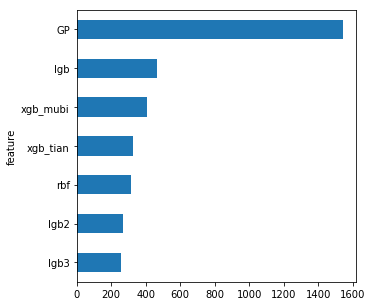

In [57]:
feature_names = list(train.columns.values)
create_feature_map(feature_names)

importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(5, 5))
plt.gcf().savefig('features_importance_xgb_stack.png')